In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer, util
import time
import torch
import matplotlib.pyplot as plt

# **Exploratory Data Analysis**

In [82]:
df = pd.read_csv('amazon_co-ecommerce_sample.csv')
df

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,NaN,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,44d6967f083825a5de36ad4865a65bcd,Batman 1966 TV Series Action Figures - The Rid...,Mattel,£22.95,5 new,3,3.0,5.0 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...,http://www.amazon.co.uk/Batman-1966-Series-Act...,DC 66 Batman Classic TV Series 6 Inch Riddler ...,Technical Details Item Weight136 g Product Dim...,DC 66 Batman Classic TV Series 6 Inch Riddler ...,NaN,NaN,Realistic // 5.0 // 31 Mar. 2014 // By\n \n...,"{""seller""=>[{""Seller_name_1""=>""Star Action Fig..."
9996,08f0747b6fc6687215ffb994c3a6fb32,"Star Wars Costume, Kids Stormtrooper Costume S...",Star Wars,£39.99,NaN,1,3.0,4.0 out of 5 stars,Characters & Brands > Star Wars > Toys,http://www.amazon.co.uk/Storm-Trooper-Costume-...,NaN,Technical Details Additional Information AS...,NaN,http://www.amazon.co.uk/Storm-Trooper-Costume-...,NaN,... what I see my grandson us going to have fu...,NaN
9997,bf6cc073f8f24e6e338190fa16f6ee9d,Defiance Lawkeeper Metal Badge Prop R

In [83]:
df.to_csv('data.csv', index=False)

### Check Category Distribution

In [5]:
df['amazon_category_and_sub_category'].value_counts()

Die-Cast & Toy Vehicles > Toy Vehicles & Accessories > Scaled Models > Vehicles    880
Figures & Playsets > Science Fiction & Fantasy                                     485
Arts & Crafts > Children's Craft Kits > Bead Art & Jewellery-Making                368
Characters & Brands > Disney > Toys                                                347
Hobbies > Trading Cards & Accessories > Packs & Sets                               317
                                                                                  ... 
Hobbies > Model Trains & Railway Sets                                                1
Cooking & Dining > Kitchen Tools & Gadgets > Barware > Coasters                      1
Women > Accessories > Eyewear & Accessories > Sunglasses                             1
Hobbies > Model Trains & Railway Sets > Accessories                                  1
Games > Drinking Games                                                               1
Name: amazon_category_and_sub_category, Len

# **Data Preprocessing & Feature Engineering**

### Check Missing Value in Used Column & Drop it

#### Column Price

In [6]:
df['price'].isna().sum()

1435

In [7]:
df = df.dropna(subset=['price'])
df['price'].isna().sum()

0

In [8]:
# Replace £123,000.20 into float
df['price'] = df['price'].apply(lambda x: float(x.replace('£','').replace(',','').split('-')[0]))

C:\Users\ACER\AppData\Local\Temp\ipykernel_35284\493512442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].apply(lambda x: float(x.replace('£','').replace(',','').split('-')[0]))


#### Column Sub Category

In [9]:
df['amazon_category_and_sub_category'].isna().sum()

552

In [10]:
df = df.dropna(subset=['amazon_category_and_sub_category'])
df['amazon_category_and_sub_category'].isna().sum()

0

##### Create Category to New Column

In [11]:
# Example 'Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains' into 4 Column
df['amazon_category_and_sub_category'] = df['amazon_category_and_sub_category'].apply(lambda x: list(map(str.strip, x.split('>'))))

In [12]:
%%time
df = df.assign(**df.amazon_category_and_sub_category.apply(pd.Series).add_prefix('category_'))
#df.assign(**pd.DataFrame(df.amazon_category_and_sub_category.values.tolist()).add_prefix('category_'))

Wall time: 1.15 s


In [13]:
# Showed Category 0 - Category 4
df.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,...,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,category_0,category_1,category_2,category_3,category_4
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,3.42,5 new,15,1.0,4.9 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Hornby-R8150-Catalogue...,...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,16.99,NaN,2,1.0,4.5 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Christmas-Holiday-Expr...,...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,9.99,2 new,17,2.0,3.9 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Classic-Train-Lights-B...,...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,39.99,NaN,1,2.0,5.0 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",NaN,...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,32.19,NaN,3,2.0,4.7 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN


#### Column Product Information / Description

In [14]:
df['product_information'].isna().sum()

52

In [15]:
df = df.dropna(subset=['product_information'])
df['product_information'].isna().sum()

0

### Final Shape

In [16]:
df.shape

(7961, 22)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7961 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      7961 non-null   object 
 1   product_name                                 7961 non-null   object 
 2   manufacturer                                 7958 non-null   object 
 3   price                                        7961 non-null   float64
 4   number_available_in_stock                    5894 non-null   object 
 5   number_of_reviews                            7951 non-null   object 
 6   number_of_answered_questions                 7329 non-null   float64
 7   average_review_rating                        7951 non-null   object 
 8   amazon_category_and_sub_category             7961 non-null   object 
 9   customers_who_bought_this_item_also_bought   7075 non-null   object 
 10  

In [16]:
df.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,...,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,category_0,category_1,category_2,category_3,category_4
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,3.42,5 new,15,1.0,4.9 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Hornby-R8150-Catalogue...,...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,16.99,NaN,2,1.0,4.5 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Christmas-Holiday-Expr...,...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,9.99,2 new,17,2.0,3.9 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Classic-Train-Lights-B...,...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,39.99,NaN,1,2.0,5.0 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",NaN,...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,32.19,NaN,3,2.0,4.7 out of 5 stars,"[Hobbies, Model Trains & Railway Sets, Rail Ve...",http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN


### Select Only Used Columns

In [18]:
df = df[['product_name', 'price', 'product_information', 'category_1']]
df

,product_name,price,product_information,category_1
0,Hornby 2014 Catalogue,3.42,Technical Details Item Weight640 g Product Dim...,Model Trains & Railway Sets
1,FunkyBuys® Large Christmas Holiday Express Fes...,16.99,Technical Details Manufacturer recommended age...,Model Trains & Railway Sets
2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,9.99,Technical Details Manufacturer recommended age...,Model Trains & Railway Sets
3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,39.99,Technical Details Item Weight259 g Product Dim...,Model Trains & Railway Sets
4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,32.19,Technical Details Item Weight159 g Product Dim...,Model Trains & Railway Sets
...,...,...,...,...
9995,Batman 1966 TV Series Action Figures - The Rid...,22.95,Technical Details Item Weight136 g Product Dim...,Collectible Figures & Memorabilia
9996,"Star Wars Costume, Kids Stormtrooper Costume S...",39.99,Technical Details Additional Information AS...,Star Wars
9997,Defiance Lawkeeper Metal Badge Prop Replica,43.99,Technical Details Item Weight159 g Product Dim...,Novelty
9998,Justice League of America Series 3 Green Lante...,49.81,Technical Details Item Weight181 g Product Dim...,Collectible Figures & Memorabilia


### Concat All Used Columns

In [19]:
df['content'] = df.agg(lambda x: f"price: {x['price']} category: {x['category_1']} product name: {x['product_name']} desc: {x['product_information']}", axis=1)
df['content']

0       price: 3.42 category: Model Trains & Railway S...
1       price: 16.99 category: Model Trains & Railway ...
2       price: 9.99 category: Model Trains & Railway S...
3       price: 39.99 category: Model Trains & Railway ...
4       price: 32.19 category: Model Trains & Railway ...
                              ...                        
9995    price: 22.95 category: Collectible Figures & M...
9996    price: 39.99 category: Star Wars product name:...
9997    price: 43.99 category: Novelty product name: D...
9998    price: 49.81 category: Collectible Figures & M...
9999    price: 21.2 category: Star Wars product name: ...
Name: content, Length: 7961, dtype: object

In [20]:
df.head()

,product_name,price,product_information,category_1,content
0,Hornby 2014 Catalogue,3.42,Technical Details Item Weight640 g Product Dim...,Model Trains & Railway Sets,price: 3.42 category: Model Trains & Railway S...
1,FunkyBuys® Large Christmas Holiday Express Fes...,16.99,Technical Details Manufacturer recommended age...,Model Trains & Railway Sets,price: 16.99 category: Model Trains & Railway ...
2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,9.99,Technical Details Manufacturer recommended age...,Model Trains & Railway Sets,price: 9.99 category: Model Trains & Railway S...
3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,39.99,Technical Details Item Weight259 g Product Dim...,Model Trains & Railway Sets,price: 39.99 category: Model Trains & Railway ...
4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,32.19,Technical Details Item Weight159 g Product Dim...,Model Trains & Railway Sets,price: 32.19 category: Model Trains & Railway ...


### Train Test Split

In [21]:
df_train, df_test = train_test_split(df, test_size=0.1,random_state=28)

In [22]:
df_train

,product_name,price,product_information,category_1,content
6382,Playmobil 5103 Bear with Caveman,14.64,Technical Details Item Weight399 g Product Dim...,Science Fiction & Fantasy,price: 14.64 category: Science Fiction & Fanta...
7276,Hardwood Wall Mounted Flag Pole,20.99,Technical Details Item Weight898 g Product Dim...,Kites & Flight Toys,price: 20.99 category: Kites & Flight Toys pro...
3150,Monsters Inc Monsters University Party Invitat...,1.49,Technical Details Manufacturer recommended age...,Disney,price: 1.49 category: Disney product name: Mon...
6051,Therizinosaurus Dinosaur Model,5.74,Technical Details Item Weight100 g Product Dim...,Dinosaurs,price: 5.74 category: Dinosaurs product name: ...
856,Diecast Model VW Beetle in Delphin Grey,14.99,Technical Details Item Weight299 g Manufacture...,Toy Vehicles & Accessories,price: 14.99 category: Toy Vehicles & Accessor...
...,...,...,...,...,...
7830,BRIO Road Repair Site,20.53,Technical Details Item Weight5 g Product Dimen...,BRIO,price: 20.53 category: BRIO product name: BRIO...
6965,Resident Evil 6 Play Arts Kai Helena Harper Ac...,49.88,Technical Details Item Weight454 g Product Dim...,Science Fiction & Fantasy,price: 49.88 category: Science Fiction & Fanta...
2083,Carrera 1/32 Evolution Aston Martin V12 Vantag...,28.15,Technical Details Item Weight481 g Product Dim...,"Slot Cars, Race Tracks & Accessories","price: 28.15 category: Slot Cars, Race Tracks ..."
5350,Bicycle Warrior Horse Deck by USPCC - Trick,2.84,Technical Details Item Weight100 g Manufacture...,Card Games,price: 2.84 category: Card Games product name:...


In [23]:
df_train.reset_index(drop=True, inplace=True)

# **Generate Product Embeddings**

In [24]:
#Encoding to embedding using pretrained model
model = SentenceTransformer('all-MiniLM-L6-v2')

list_content = df_train['content'].to_list()

corpus_embeddings = model.encode(list_content, show_progress_bar=True, convert_to_tensor=True)
corpus_embeddings = corpus_embeddings.to('cpu')

Batches:   0%|          | 0/224 [00:00<?, ?it/s]

## **Fast Clustering**

In [25]:
print("Start clustering")
start_time = time.time()

clusters = util.community_detection(corpus_embeddings, min_community_size=3, threshold=0.8)

print("Clustering done after {:.2f} sec".format(time.time() - start_time))

Start clustering
Clustering done after 19.69 sec


### Show Cluster

In [26]:
for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster[0:3]:
        print("\t", list_content[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", list_content[sentence_id])


Cluster 1, #1176 Elements 
	 price: 43.99 category: Shops & Accessories product name: Melissa & Doug Shopping Trolley desc: Technical Details Item Weight5 Kg Product Dimensions43.7 x 38.6 x 35.6 cm Manufacturer recommended age:3 years and up Item model number14071 Assembly RequiredNo Batteries Required?No Batteries Included?No    Additional Information ASINB0033UX0BU Customer Reviews amznJQ.onReady('popover', function() { (function($) { if($.fn.acrPopover) return; var popoverConfig = { showOnHover:true, showCloseButton: "ontouchstart" in document.documentElement, width: null, location:'bottom', locationAlign:'left', locationOffset:[-20,0], group: 'reviewsPopover', clone:false, hoverHideDelay:300 }; $.fn.acrPopover = function() { return this.each(function() { var $this = $(this); if(!$this.data('init') && typeof $this.amazonPopoverTrigger === 'function') { $this.data('init', 1); var ajaxURL = '/gp/customer-reviews/common/du/displayHistoPopAjax.html?' + '&ASIN=' + $this.attr('name') + '

### Total Data Clustered

In [27]:
sum_clustered =0 
for i in range(len(list_content)):
    tf = any(i in x for x in clusters)
    if tf:
        sum_clustered += 1

sum_clustered

6325

## **Remove Community Cluster Duplicate**

In [28]:
lists_elements_count = 0
 
for ele in clusters:
    lists_elements_count += len(ele)    
 
print('length of list of lists is =',lists_elements_count)

length of list of lists is = 6325


### So there is no duplicate.

In [29]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

In [30]:
idx_clustered = {}
new_cluster = []

for index, i in enumerate(clusters):
    temp_list = clusters[index]
    temp_dup = []
    for j in clusters[index]:
        if j in idx_clustered:
            temp_dup.append(j[:])
        else:
            idx_clustered[j] = 1
    
    delete_multiple_element(temp_list, temp_dup)
    new_cluster.append(temp_list[:])

# **Retraining**

### Total data not clustered

In [31]:
single_member = [i for i in range(len(list_content)) if i not in idx_clustered]
len(single_member)

839

### Get small member cluster (below 10 member) & large member (more than 10 member)

In [32]:
small_member = []
large_member = []
for index, i in enumerate(clusters):
    if len(i) < 11:
        for j in clusters[index]:
            small_member.append(j)
    else:
        large_member.append(i[:])

print(len(small_member))
print(len(large_member))

1360
79


### Total Data Large Member

In [33]:
lists_elements_count = 0

for ele in large_member:
    lists_elements_count += len(ele)    

print('length of list of lists is =',lists_elements_count)

length of list of lists is = 4965


### Concat Small and not clustered member into 1 list

In [34]:
concate_small_single = [*small_member, *single_member]
len(concate_small_single)

2199

### Save count of member & member before recluster

In [35]:
before_recluster = [0, 0, 0, 0, 0, 0]
before_recluster[0] = len(single_member)
before_recluster[1] = len(small_member)

for cluster in clusters:
    if (len(cluster) > 10) and (len(cluster) <= 30):
        before_recluster[2] += len(cluster)
    elif (len(cluster) > 30) and (len(cluster) <= 50):
        before_recluster[3] += len(cluster)
    elif (len(cluster) > 50) and (len(cluster) <= 100):
        before_recluster[4] += len(cluster)
    elif len(cluster) > 100:
        before_recluster[5] += len(cluster)

before_recluster

[839, 1360, 706, 630, 706, 2923]

In [36]:
import copy
cluster_before = copy.deepcopy(clusters)

In [37]:
#cluster_before = clusters[:]

### **Note: Due to list append python can change older list, so we need to run from fast clustering again**

## Retraining Using Nearest Member to Member

In [38]:
def retrain(small_list, big_list, model_retrain, all_list_content, all_cluster):
    bigger_list = copy.deepcopy(big_list)
    all_index_cluster = copy.deepcopy(all_cluster)


    # Change from index to content
    content_group =[]
    for i in range(len(bigger_list)):
        temp_content_group = []
        for j in range(len(bigger_list[i])):
            temp_content_group.append(all_list_content[bigger_list[i][j]])
        
        content_group.append(temp_content_group[:])
    
    # Change Embedding big member group
    list_embedding_big = []
    for content_big in content_group:
        list_embedding_big.append(model_retrain.encode(content_big, convert_to_tensor=True).to('cpu'))
    
    

    content_small_list =[]
    for i in range(len(small_list)):
        content_small_list.append(all_list_content[small_list[i]])
    
    list_embedding_small = []
    for content_small in content_small_list:        
        list_embedding_small.append(model_retrain.encode(content_small, convert_to_tensor=True).to('cpu'))

    
    print('Starting to Clustering')
    list_not_clustered = []

    for idx_small, small_embed in enumerate(list_embedding_small):
        temp_highest_sim = 0
        temp_cluster = -1

        real_index = small_list[idx_small]

        small_embed = small_embed.unsqueeze(0)


        for idx_big, embed_big in enumerate(list_embedding_big):
            max_sim_big = cosine_similarity(small_embed, embed_big).max()
            if max_sim_big > temp_highest_sim:
                temp_highest_sim = max_sim_big
                temp_cluster = idx_big

        

        # Threshold
        if temp_highest_sim > 0.8:    
            founded = False
            for i in range(len(all_index_cluster)): # If had clustered before
                if real_index in all_index_cluster[i]:
                    all_index_cluster[i].remove(real_index)
                    all_index_cluster[temp_cluster].append(real_index)
                    founded = True
                    break;

            if founded == False:
                all_index_cluster[temp_cluster].append(real_index)

        else:
            founded = False
            for i in range(len(all_index_cluster)): # If had clustered before
                if real_index in all_index_cluster[i]:
                    founded = True
                    break;
            if founded == False:
                list_not_clustered.append(real_index)

    
    return all_index_cluster, list_not_clustered

In [39]:
%%time
recluster_list, not_clustered_list =  retrain(concate_small_single, large_member, model, list_content, clusters)

Starting to Clustering
Wall time: 12min 22s


### Total data still not clustered after reclustering

In [40]:
len(not_clustered_list)

588

### Total data after reclustered

In [46]:
lists_elements_count = 0

for ele in recluster_list:
    lists_elements_count += len(ele)    
 
print('length of list of lists is =',lists_elements_count)

length of list of lists is = 6576


### Total data before reclustered

In [47]:
lists_elements_count = 0

for ele in cluster_before:
    lists_elements_count += len(ele)    

print('length of list of lists is =',lists_elements_count)

length of list of lists is = 6325


In [48]:
# Total Data
6547 + 617

7164

In [49]:
2745 + 600 + 3819

7164

### Save Count of Member & Member after reclustering member to member

In [50]:
after_recluster = [0, 0, 0, 0, 0, 0]
after_recluster[0] = len(not_clustered_list)

for cluster in recluster_list:
    if (len(cluster) > 1) and (len(cluster) <= 10):
        after_recluster[1] += len(cluster)
    elif (len(cluster) > 10) and (len(cluster) <= 30):
        after_recluster[2] += len(cluster)
    elif (len(cluster) > 30) and (len(cluster) <= 50):
        after_recluster[3] += len(cluster)
    elif (len(cluster) > 50) and (len(cluster) <= 100):
        after_recluster[4] += len(cluster)
    elif len(cluster) > 100:
        after_recluster[5] += len(cluster)

after_recluster

[588, 213, 696, 448, 1285, 3918]

In [51]:
before_recluster

[839, 1360, 706, 630, 706, 2923]

## Retraining Using Nearest Member to Centroid

### Total data not clustered

In [52]:
single_member_centroid = [i for i in range(len(list_content)) if i not in idx_clustered]
len(single_member_centroid)

839

### Get small member cluster (below 10 member) & large member (more than 10 member)

In [53]:
small_member_cen = []
large_member_cen = []
for index, i in enumerate(cluster_before):
    if len(i) < 11:
        for j in cluster_before[index]:
            small_member_cen.append(j)
    else:
        large_member_cen.append(i[:])

print(len(small_member_cen))
print(len(large_member_cen))

1360
79


### Total Data Large Member

In [54]:
lists_elements_count = 0

for ele in large_member_cen:
    lists_elements_count += len(ele)    

print('length of list of lists is =',lists_elements_count)

length of list of lists is = 4965


### Concat Small and not clustered member into 1 list

In [55]:
concate_small_single_cen = [*small_member_cen, *single_member_centroid]
len(concate_small_single_cen)

2199

In [56]:
import copy
cluster_before_cen = copy.deepcopy(cluster_before)

In [57]:
def retrain_centroid(small_list, big_list, model_retrain, all_list_content, all_cluster):
    bigger_list = copy.deepcopy(big_list)
    all_index_cluster = copy.deepcopy(all_cluster)


    # Change from index to content
    content_group =[]
    for i in range(len(bigger_list)):
        temp_content_group = []
        for j in range(len(bigger_list[i])):
            temp_content_group.append(all_list_content[bigger_list[i][j]])
        
        content_group.append(temp_content_group[:])
    
    # Change Embedding big member group
    list_embedding_big = []
    for content_big in content_group:
        list_embedding_big.append(model_retrain.encode(content_big, convert_to_tensor=True).to('cpu'))
    
    # Get Centroid of every cluster
    list_embedding_centroid = []
    for index, embed in enumerate(list_embedding_big):
        list_embedding_centroid.append(torch.tensor([sum(i)/len(embed) for i in zip(*embed)]))
    

    content_small_list =[]
    for i in range(len(small_list)):
        content_small_list.append(all_list_content[small_list[i]])
    
    list_embedding_small = []
    for content_small in content_small_list:        
        list_embedding_small.append(model_retrain.encode(content_small, convert_to_tensor=True).to('cpu'))

    
    print('Starting to Clustering')
    list_not_clustered = []

    for idx_small, small_embed in enumerate(list_embedding_small):
        temp_highest_sim = 0
        temp_cluster = -1

        real_index = small_list[idx_small]

        small_embed = small_embed.unsqueeze(0)


        for idx_big, embed_big in enumerate(list_embedding_centroid):
            max_sim_big = cosine_similarity(small_embed, embed_big.unsqueeze(0)).max()
            if max_sim_big > temp_highest_sim:
                temp_highest_sim = max_sim_big
                temp_cluster = idx_big
        

        # Threshold
        if temp_highest_sim > 0.8:    
            founded = False
            for i in range(len(all_index_cluster)): # If had clustered before
                if real_index in all_index_cluster[i]:
                    all_index_cluster[i].remove(real_index)
                    all_index_cluster[temp_cluster].append(real_index)
                    founded = True
                    break;

            if founded == False:
                all_index_cluster[temp_cluster].append(real_index)

        else:
            founded = False
            for i in range(len(all_index_cluster)): # If had clustered before
                if real_index in all_index_cluster[i]:
                    founded = True
                    break;
            if founded == False:
                list_not_clustered.append(real_index)


    
    return all_index_cluster, list_not_clustered

In [58]:
%%time
recluster_list_cen, not_clustered_list_cen =  retrain_centroid(concate_small_single_cen, large_member_cen, model, list_content, cluster_before)

Starting to Clustering
Wall time: 13min 25s


In [59]:
lists_elements_count = 0

for ele in recluster_list_cen:
    lists_elements_count += len(ele)    

print('length of list of lists is =',lists_elements_count)

length of list of lists is = 6607


In [60]:
len(not_clustered_list_cen)

557

In [61]:
907 + 6257

7164

### Save count of member & centroid after recluster

In [62]:
after_recluster_cen = [0, 0, 0, 0, 0, 0]
after_recluster_cen[0] = len(not_clustered_list_cen)

for cluster in recluster_list_cen:
    if (len(cluster) > 1) and (len(cluster) <= 10):
        after_recluster_cen[1] += len(cluster)
    elif (len(cluster) > 10) and (len(cluster) <= 30):
        after_recluster_cen[2] += len(cluster)
    elif (len(cluster) > 30) and (len(cluster) <= 50):
        after_recluster_cen[3] += len(cluster)
    elif (len(cluster) > 50) and (len(cluster) <= 100):
        after_recluster_cen[4] += len(cluster)
    elif len(cluster) > 100:
        after_recluster_cen[5] += len(cluster)
    elif len(cluster) == 1:
        after_recluster_cen[0] += 1

after_recluster_cen

[615, 290, 643, 610, 1358, 3648]

In [63]:
before_recluster

[839, 1360, 706, 630, 706, 2923]

### Visualization

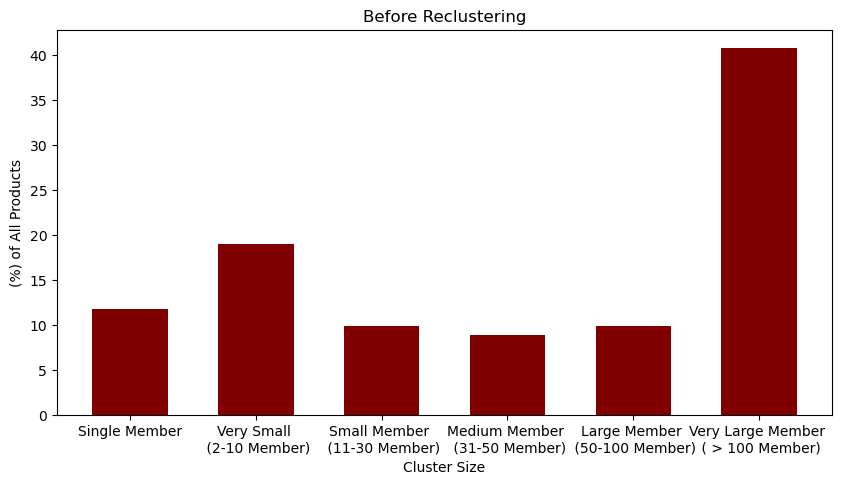

In [64]:
fig = plt.figure(figsize = (10, 5))
#ax.plot(after_recluster_cen)
lab = ['Single Member',
'Very Small \n (2-10 Member)',
'Small Member \n (11-30 Member)',
'Medium Member \n (31-50 Member)',
'Large Member \n (50-100 Member)',
'Very Large Member \n ( > 100 Member)']

recluster_cen_viz = [x/sum(before_recluster)*100 for x in before_recluster]

plt.bar(lab, recluster_cen_viz, color ='maroon',
        width = 0.6)

plt.xlabel("Cluster Size")
plt.ylabel("(%) of All Products")
plt.title("Before Reclustering")

plt.show()

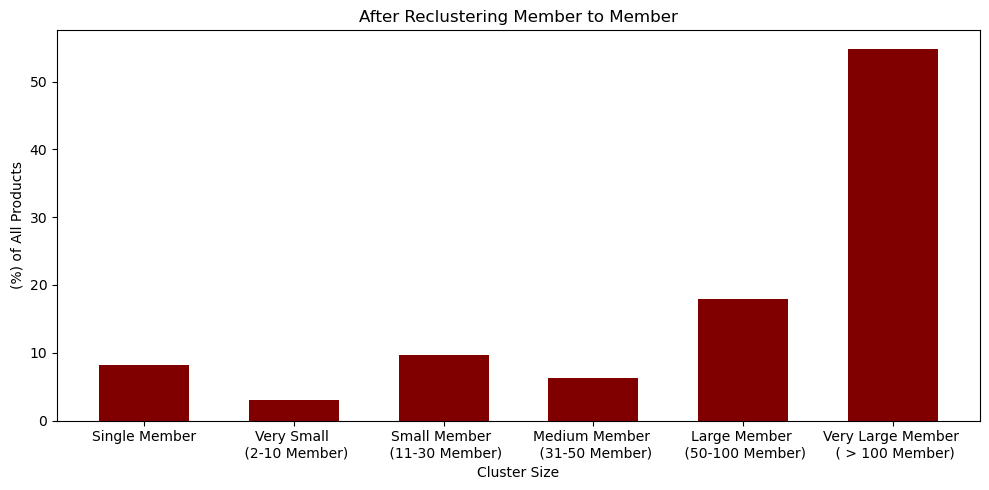

In [65]:
fig = plt.figure(figsize = (10, 5))
#ax.plot(after_recluster_cen)
lab = ['Single Member',
'Very Small \n (2-10 Member)',
'Small Member \n (11-30 Member)',
'Medium Member \n (31-50 Member)',
'Large Member \n (50-100 Member)',
'Very Large Member \n ( > 100 Member)']

recluster_cen_viz = [x/sum(after_recluster)*100 for x in after_recluster]

plt.bar(lab, recluster_cen_viz, color ='maroon',
        width = 0.6)

plt.xlabel("Cluster Size")
plt.ylabel("(%) of All Products")
plt.title("After Reclustering Member to Member")

plt.tight_layout()

plt.show()

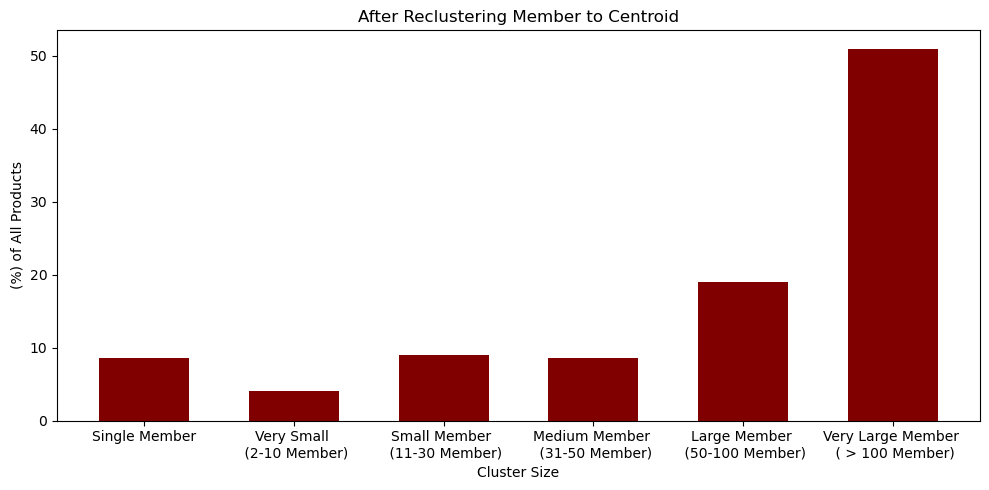

In [66]:
fig = plt.figure(figsize = (10, 5))
#ax.plot(after_recluster_cen)
lab = ['Single Member',
'Very Small \n (2-10 Member)',
'Small Member \n (11-30 Member)',
'Medium Member \n (31-50 Member)',
'Large Member \n (50-100 Member)',
'Very Large Member \n ( > 100 Member)']

recluster_cen_viz = [x/sum(after_recluster_cen)*100 for x in after_recluster_cen]

plt.bar(lab, recluster_cen_viz, color ='maroon',
        width = 0.6)

plt.xlabel("Cluster Size")
plt.ylabel("(%) of All Products")
plt.title("After Reclustering Member to Centroid")

plt.tight_layout()

plt.show()

# **Evaluation**

### Score before recluster

In [71]:
%%time
# Change from index to content
content_group_before =[]
for i in range(len(cluster_before)):
    temp_content_group = []
    for j in range(len(cluster_before[i])):
        temp_content_group.append(list_content[cluster_before[i][j]])
    
    content_group_before.append(temp_content_group[:])

# Change Embedding big member group
list_embedding_before = []
for content_big in content_group_before:
    list_embedding_before.append(model.encode(content_big, convert_to_tensor=True).to('cpu'))

Wall time: 7min 13s


In [72]:
%%time
x_before = []
label_before = []
for index, per_cluster in enumerate(list_embedding_before):
    for embed in per_cluster:
        x_before.append(embed.cpu().detach().numpy())
        label_before.append(index)

print(len(x_before))
print(len(label_before))

6325
6325
Wall time: 81.2 ms


In [73]:
silhouette_score(x_before, label_before)

0.023081938

### Score after recluster

In [74]:
%%time
# Change from index to content
content_group_after =[]
for i in range(len(recluster_list)):
    temp_content_group = []
    for j in range(len(recluster_list[i])):
        temp_content_group.append(list_content[recluster_list[i][j]])
    
    content_group_after.append(temp_content_group[:])

# Change Embedding big member group
list_embedding_after = []
for content_big in content_group_after:
    list_embedding_after.append(model.encode(content_big, convert_to_tensor=True).to('cpu'))

RuntimeError: stack expects a non-empty TensorList

In [75]:
%%time
x_after = []
label_after = []
for index, per_cluster in enumerate(list_embedding_after):
    for embed in per_cluster:
        x_after.append(embed.cpu().detach().numpy())
        label_after.append(index)

print(len(x_after))
print(len(label_after))

6347
6347
Wall time: 39 ms


In [76]:
silhouette_score(x_after, label_after)

0.07668538

### Score after recluster centroid

In [77]:
print(len(recluster_list_cen))
recluster_list_cen = [s for s in recluster_list_cen if s != []]
print(len(recluster_list_cen))

379
222


In [78]:
%%time
# Change from index to content
content_group_after =[]
for i in range(len(recluster_list_cen)):
    temp_content_group = []
    for j in range(len(recluster_list_cen[i])):
        temp_content_group.append(list_content[recluster_list_cen[i][j]])
    
    content_group_after.append(temp_content_group[:])

# Change Embedding big member group
list_embedding_after_cen = []
for content_big in content_group_after:
    list_embedding_after_cen.append(model.encode(content_big, convert_to_tensor=True).to('cpu'))

Wall time: 6min 50s


In [79]:
%%time
x_after_cen = []
label_after_cen = []
for index, per_cluster in enumerate(list_embedding_after_cen):
    for embed in per_cluster:
        x_after_cen.append(embed.cpu().detach().numpy())
        label_after_cen.append(index)

print(len(x_after_cen))
print(len(label_after_cen))

6607
6607
Wall time: 234 ms


In [80]:
silhouette_score(x_after_cen, label_after_cen)

0.051977597

--------------------------------------------------------------------------------------------------------------------------------